In [1]:
# Setup cells - not for publication

import xarray as xr
import os, sys
fn = os.path.join("../data/anomaly_timeseries.nc")
anomalies_ds = xr.open_dataset(fn)
anomalies_df = anomalies_ds.to_dataframe().reset_index()

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use(['seaborn-ticks', 'seaborn-talk'])

import warnings; warnings.simplefilter("ignore", category=Warning)

/Users/daniel/anaconda/lib/python3.5/site-packages/xarray/core/formatting.py:16: FutureWarning: The pandas.tslib module is deprecated and will be removed in a future version.
  from pandas.tslib import OutOfBoundsDatetime


Last Fall, I wrote a [short piece]({filename}/blog/declarative-visualization-in-python.md) on the state of toolkits for declarative visualization within Python. As a brief re-cap, most Python users lean on [matplotlib](http://matplotlib.org/) to plot their data (although the [Python visualization landscape is rapidly evolving!](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=5&cad=rja&uact=8&ved=0ahUKEwjmiqKx5PTUAhXh7YMKHePxBXwQtwIIPzAE&url=https%3A%2F%2Fwww.youtube.com%2Fwatch%3Fv%3DFytuB8nFHPQ&usg=AFQjCNFXC_Cr93OAT8-I8q8V8xhx5VHrqg)). When it comes to building complex scientific visualizations which try to summarize lots of data in a succinct way, matplotlib *works*, but is difficult to use; you often have to write very long scripts and use weird tricks to get your data to look the way you want - and then you probably have to go into Illustrator and clean it up afterwards.

In the following few steps, I'll create one such plot. These plot will compare 6 different climate model simulations - specifically, global-average surface temperature anomalies (versus each simulation's long-term average for a baseline). The 6 simulations comprise a 2x3 ensemble where I've simulated two different emissions cases with three different model configurations. The data a series of monthly means for each simulation. Prepping and processing this data is trivial, and was just a handful of lines of code using [experiment](https://github.com/darothen/experiment) and [pandas](http://pandas.pydata.org/). From this code I've saved a `DataFrame` in tidy format:

In [2]:
anomalies_df.head()

,act,aer,time,month,RN,TS
0,arg_comp,PD,2001-02-01,2,1.065971,0.669912
1,arg_comp,PD,2001-03-01,3,-0.300655,0.391183
2,arg_comp,PD,2001-04-01,4,-0.538509,0.501736
3,arg_comp,PD,2001-05-01,5,0.249762,0.611735
4,arg_comp,PD,2001-06-01,6,-0.593146,0.528018


My actual plot is going to have 3 sub-panels: one for each model configuration. Each panel will contain the monthly timeseries for each emissions case using that configuration; I want them to appear as different colors. I also want to add a smoothing function to each timeseries so I can quickly eyeball what's going on. As I [previously showed]({filename}/blog/declarative-visualization-in-python.md), this is easy to do with matplotlib, but it requires a lot of boilerplate. 

## Enter `plotnine`

Since I wrote my post last Fall, there's a newcomer to the Python declarative visualization community. [plotnine](https://plotnine.readthedocs.io/en/stable/index.html) aims to be a fully-featured implementation of [ggplot2](http://ggplot2.org/) for Python. Really, ggplot2 is the 'gold standard' for grammar of graphics toolkits; I sometimes drop into R just to quickly whip up a plot using it. 

But with plotnine, I can essentially emulate my ggplot2 code directly within Python. Let's build our plot using these core concepts.

We begin by mapping our data to some aeshtetics, and adding some geometries to our plot to represent these relationships.

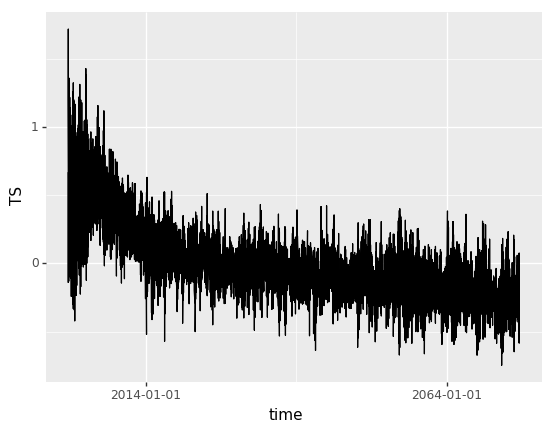

<ggplot: (-9223372036564749901)>


In [3]:
from plotnine import *

field = 'TS'

p = (
    ggplot(anomalies_df, aes('time', field))
    + geom_line()
)
print(p)

Like magic, we have an aggregation plot! However, we're going to want to break down our different panels and colors - to do so, we'll facet like we would with [seaborn](http://seaborn.pydata.org), and use a factored "color" mapping to one of our simulation ID fields. Adding the colors is easy: we just call our variable a "factor", and map it at our top `ggplot` invocation and when we apply the smoothing function.

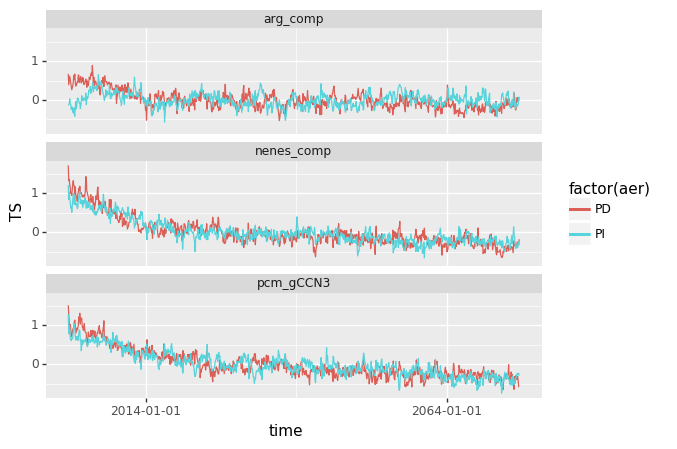

<ggplot: (-9223372036564663594)>


In [4]:
from plotnine import *

field = 'TS'

p = (
    ggplot(anomalies_df, aes('time', 'TS', color='factor(aer)'))
    + geom_line()
    + facet_wrap('~ act', dir='v')
)
print(p)

It's *that* easy. Note that there are some minor differences in how we supply arguments to the functions versus in standard ggplot2 (specifically how we indicate a factor by including it in the string representing our field). 

Analytically, we just have one more thing to add to the plot: our lowess smoother. In ggplot2 world, we simply add a `stat_smooth` function into our pipeline. Here, we do the same. plotnine allows you to supply your own smoother functions, but here we'll use a built-in one (provided via statsmodels).

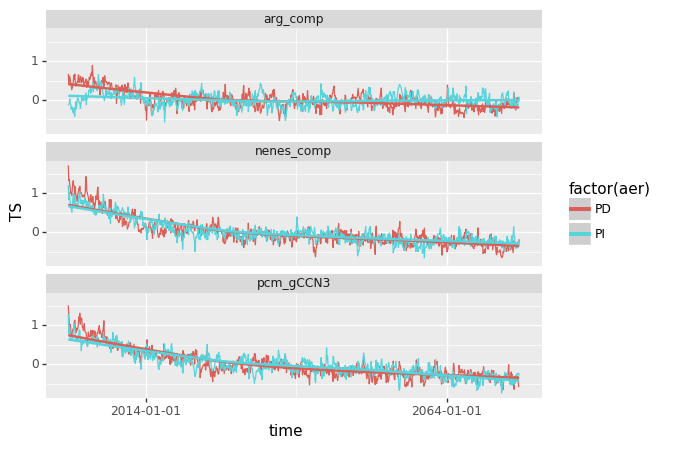

<ggplot: (290751366)>


In [5]:
from plotnine import *

field = 'TS'

p = (
    ggplot(anomalies_df, aes('time', 'TS', color='factor(aer)'))
    + geom_line()
    + stat_smooth(aes(color='factor(aer)'), method='lowess')
    + facet_wrap('~ act', dir='v')
)
print(p)

That's essentially it - we have our core plot now! We can also tweak all of the aesthetics of the plot. I'll start with the most complicated part - 'nice' tick labels on our x-axis. This is the biggest weakness with plotnine right now; it doesn't yet have smart date labeling functionality. But we can easily construct our own labels by specifying where the ticks should occur ("breaks") and what their corresponding "labels" should be.

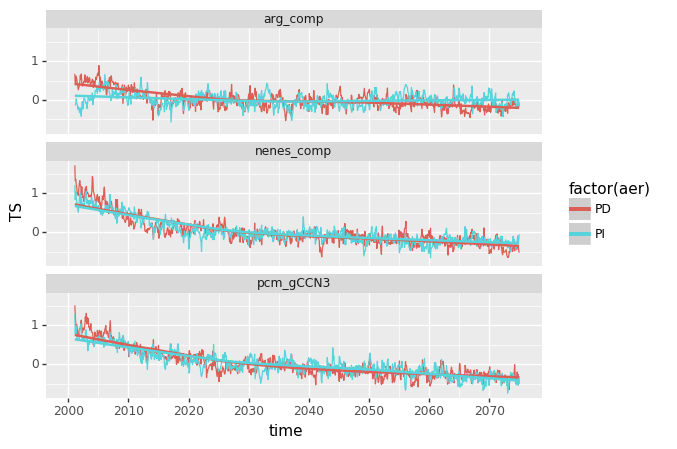

<ggplot: (-9223372036563750631)>


In [6]:
from pandas import date_range
from plotnine import *

field = 'TS'

limits = ('2000-01', '2075-01')
breaks = date_range(*limits, freq='10AS')
labels = breaks.year

p = (
    ggplot(anomalies_df, aes('time', field, color='factor(aer)'))
    + geom_line()
    + stat_smooth(aes(color='factor(aer)'), method='lowess')
    + scale_x_date(
        limits=limits,
        breaks=breaks.astype('str').tolist(), 
        labels=labels.astype('str').tolist()
    )
    + facet_wrap(('act', ), dir='v')
)
print(p)

Next, let's fix our plot color theme. We can use a nice colorbrewer palette, and seaborn-like aesthetics.

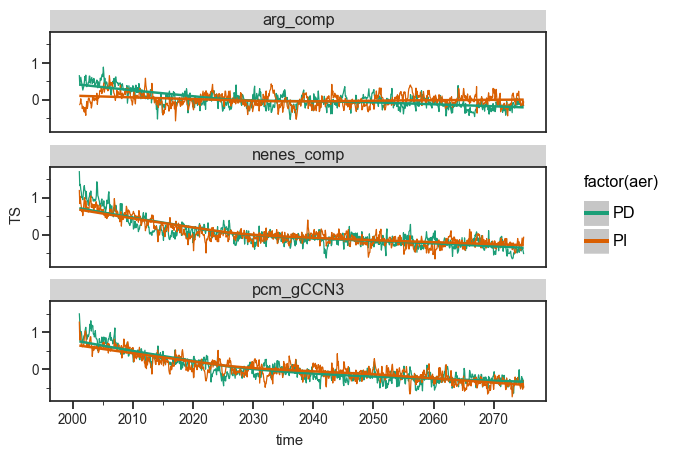

<ggplot: (291198342)>


In [7]:
from pandas import date_range
from plotnine import *

field = 'TS'

limits = ('2000-01', '2075-01')
breaks = date_range(*limits, freq='10AS')
labels = breaks.year

p = (
    ggplot(anomalies_df, aes('time', field, color='factor(aer)'))
    + geom_line()
    + stat_smooth(aes(color='factor(aer)'), method='lowess')
    + scale_color_brewer('qual', 'Dark2')
    + scale_x_date(
        limits=limits,
        breaks=breaks.astype('str').tolist(), 
        labels=labels.astype('str').tolist()
    )
    + facet_wrap(('act', ), dir='v')
    + theme_seaborn(style='ticks', context='talk', font_scale=0.75)
)
print(p)

I prefer cleaner plots with fewer lines and chart elements save for what is really necessary. We'll modify the theme to kill the top/right spines, and add a y=0 line to guide our eye inside the plot.

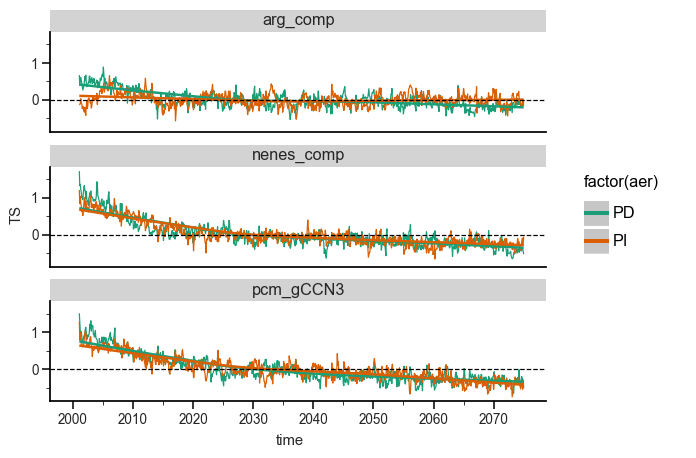

<ggplot: (292675069)>


In [8]:
from pandas import date_range
from plotnine import *

field = 'TS'

limits = ('2000-01', '2075-01')
breaks = date_range(*limits, freq='10AS')
labels = breaks.year

p = (
    ggplot(anomalies_df, aes('time', field, color='factor(aer)'))
    + geom_line()
    + stat_smooth(aes(color='factor(aer)'), method='lowess')
    + scale_color_brewer('qual', 'Dark2')
    + scale_x_date(
        limits=limits,
        breaks=breaks.astype('str').tolist(), 
        labels=labels.astype('str').tolist()
    )
    + facet_wrap(('act', ), dir='v')
    + geom_hline(aes(yintercept=0.), linetype='dashed')
    + theme_seaborn(style='ticks', context='talk', font_scale=0.75)
    + theme(
            axis_line_x=element_line(color='black'),
            axis_line_y=element_line(color='black')
    )    
)
print(p)

Finally, let's tweak the y-axis and legend labels, and clean up the facet titles to get rid of the backgroud grey box. In ggplot2/plotnine, the facet titles are an element called a "strip".

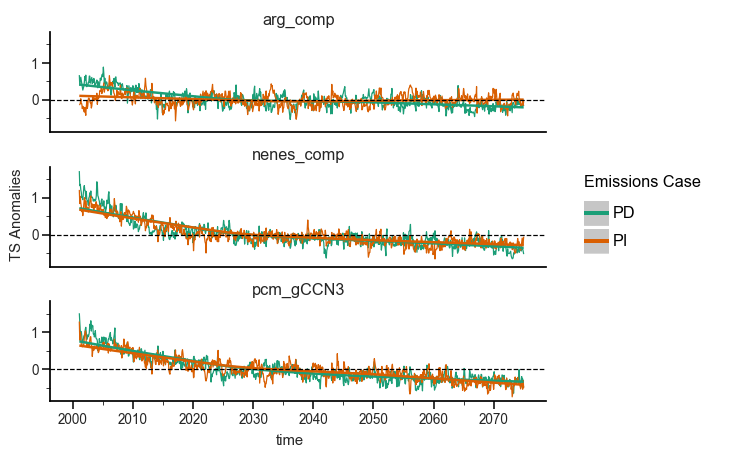

<ggplot: (290997203)>


In [9]:
from pandas import date_range
from plotnine import *

field = 'TS'

limits = ('2000-01', '2075-01')
breaks = date_range(*limits, freq='10AS')
labels = breaks.year

p = (
    ggplot(anomalies_df, aes('time', field, color='factor(aer)'))
    + geom_line()
    + stat_smooth(aes(color='factor(aer)'), method='lowess')
    + scale_color_brewer('qual', 'Dark2')
    + scale_x_date(
        limits=limits,
        breaks=breaks.astype('str').tolist(), 
        labels=labels.astype('str').tolist()
    )
    + guides(
        color=guide_legend(title='Emissions Case')
    )
    + ylab('{} Anomalies'.format(field))
    + facet_wrap(('act', ), dir='v')
    + geom_hline(aes(yintercept=0.), linetype='dashed')
    + theme_seaborn(style='ticks', context='talk', font_scale=0.75)
    + theme(strip_background=element_rect(fill='white'),
            axis_line_x=element_line(color='black'),
            axis_line_y=element_line(color='black'),
    )    
)
print(p)

## Putting it all together

Finally, we can combine all of the previous code snippets (including imports) to produce our final figure. We actually haven't really solved our "lines of code" problem... *however*, the code we've written is fundamentally different than the imperative matplotlib code which could reproduce this figure. In fact, most of the code is just tweaking plot aesthetics, which we could easily save as a theme and never have to worry about again - and if you're in an exploratory data analysis mode, you probably wouldn't even other with aesthetics in the first place!

If you can get over the length and verbosity of the code, you're left with a "recipe" for **what** you want your plot to contain. That lets you focus on interpreting the results, instead of building plotting scripts. 

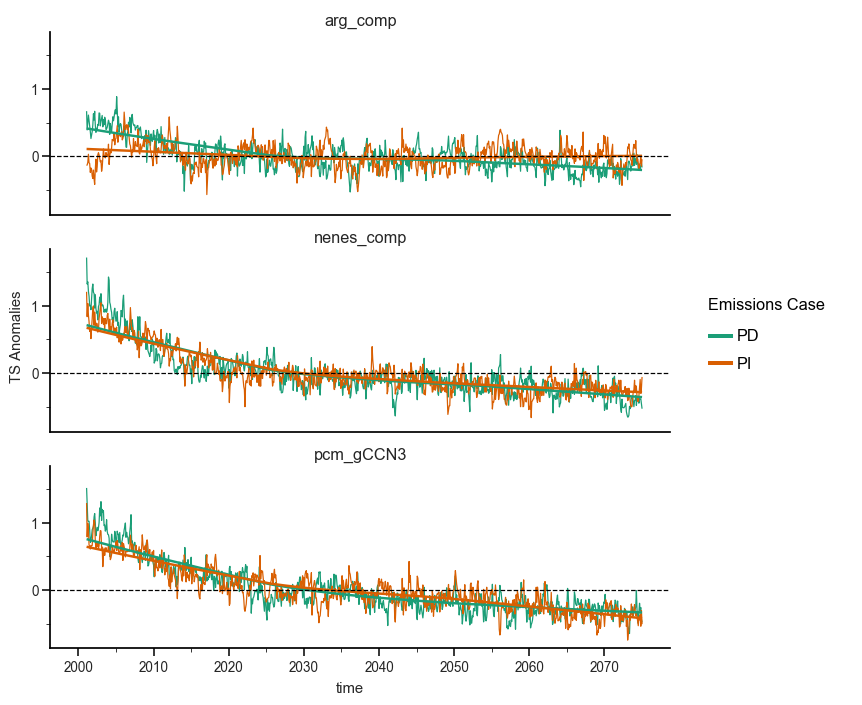

<ggplot: (291527856)>


In [5]:
from pandas import date_range
from plotnine import *

field = 'TS'

limits = ('2000-01', '2075-01')
breaks = date_range(*limits, freq='10AS')
labels = breaks.year

p = (
    ggplot(anomalies_df, aes('time', field, color='factor(aer)'))
    + geom_line()
    + stat_smooth(aes(color='factor(aer)'), method='lowess', se=False)
    + scale_color_brewer('qual', 'Dark2')
    + scale_x_date(
        limits=limits,
        breaks=breaks.astype('str').tolist(), 
        labels=labels.astype('str').tolist()
    )
    + guides(
        color=guide_legend(title='Emissions Case')
    )
    + ylab('{} Anomalies'.format(field))
    + facet_wrap(('act', ), dir='v')
    + geom_hline(aes(yintercept=0.), linetype='dashed')
    + theme_seaborn(style='ticks', context='talk', font_scale=0.75)
    + theme(figure_size=(8, 8),
            strip_background=element_rect(fill='white'),
            axis_line_x=element_line(color='black'),
            axis_line_y=element_line(color='black'),
            legend_key=element_rect(fill='white', color='white') 
    )    
)
print(p)

Note that here we've also tweaked the plot size and attempted to get rid of the grey background in the legend "keys". For some reason, this isn't working at the moment, but this should be the correct calling sequence.

## Differences with Existing Toolkits

`plotnine` is a worthy heir to ggplot2. It's more fully-featured than yhat's ggplot project and the altair project, although the latter aims for a slightly different use-case (translating to d3-esque plotting frameworks). It's not quite as low-level as seaborn, but could probably reproduce most seaborn figures with ease. 

My biggest issue with plotnine is the lack of examples, but that'll probably change as more users try it out and contribute them to the community. A smaller issue is that using plotnine requires you to abandon your years worth of knowledge about matplotlib. It would be *awesome* if I could go in after I construct a plot and then tweak the aesthetics using my working knowledge of matplotlib. Sometimes there are weird edge cases that cause plotnine plots to break (although as an important note, resetting your kernel tends to fix them. I have *no idea* why this happens and I can't faithfully reproduce it), and they arise from complicated layering of plot elements. If I could do my core plotting via plotnine, then have a `FacetGrid`-like object to manually tweak (fixing spines, ticks, labels, annotations, etc), that would be an ideal situation.

---

If this is useful to you, please [check out plotnine on github](https://github.com/has2k1/plotnine) and encourage its author to keep developing it!